### Mode Convertion of a Taper Waveguide

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import meep as mp

mp.verbosity(1);

     prism, center = (-4,0,5e+19)
          height 1e+20, axis (0,0,1), sidewall angle: 0 radians, 4 vertices:
          (-32,0.2,0)
          (16,0.2,0)
          (16,-0.2,0)
          (-16,-0.2,0)
          dielectric constant epsilon diagonal = (12.298,12.298,12.298)


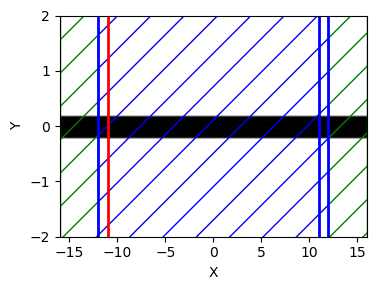

In [6]:
resolution = 25  # pixels/μm
lcen = 1.31  # mode wavelength
fcen = 1/lcen  # mode frequency
w1 = 0.4  # width of waveguide 1
w2 = 12.0  # width of waveguide 2
w_oxide = 2.0  # width of oxide cladding
L1 = 2.0  # length of waveguides 1 (at least 2 µm)
L2 = 2.0  # length of waveguides 2 (at least 2 µm)
Lt = 20.0  # length of taper waveguide
d_oxide = 2.0   # width of oxide cladding
d_pml_x = 4.0   # size of PML in x direction
d_pml_y = 2.0   # size of PML in y direction
Si = mp.Medium(index=3.50685)
SiO2 = mp.Medium(index=1.44672)

lx = L1 + Lt + L2
ly = w_oxide + max(w1,w2) + w_oxide
sx = d_pml_x + lx + d_pml_x
sy = d_pml_y + ly + d_pml_y
cell_size = mp.Vector3(sx, sy, 0)
boundary_layers = [mp.PML(d_pml_x, direction=mp.X), mp.PML(d_pml_y, direction=mp.Y)]
# symmetries = [mp.Mirror(mp.Y)]

## Source
sources = [mp.EigenModeSource(src = mp.GaussianSource(fcen, fwidth=0.1*fcen),  # Gaussian-pulse source
                              center = mp.Vector3(-lx/2+1, 0),
                              size = mp.Vector3(0, ly),
                              eig_parity = mp.ODD_Z + mp.EVEN_Y,  # Ez polarization
                              eig_match_freq = True)]  # Default True, tries to find a mode with the same frequency as the src property

## Input waveguide
vertices = [mp.Vector3(-sx/1, w1/2),
            mp.Vector3(sx/2, w1/2),
            mp.Vector3(sx/2, -w1/2),
            mp.Vector3(-sx/2, -w1/2)]

## Simulation object
sim = mp.Simulation(resolution = resolution,
                    cell_size = cell_size,
                    boundary_layers = boundary_layers,
                    geometry = [mp.Prism(vertices, height=mp.inf, material=Si)],
                    sources = sources,
                    # symmetries = symmetries,  # Results in discontinuous field across y=0 ?
                    default_material = SiO2)

## Monitor
## add_flux(fcen, df, nfreq, freq, FluxRegions)
## nfreq of equally space frequencies covering the range fcen-df/2 to fcen+df/2
## or freq array/list of arbitrary frequencies
mon_pt = mp.Vector3(lx/2-1, 0)
flux = sim.add_flux(fcen, 0, 1, 
                    mp.FluxRegion(center = mon_pt, 
                                  size = mp.Vector3(0, ly)))

field = sim.add_dft_fields([mp.Ez], fcen, 0, 1,
                           center = mp.Vector3(0, 0),
                           size = mp.Vector3(lx, ly))

fig, ax = plt.subplots(figsize=(4,3))
sim.plot2D(ax=ax)
ax.axis("auto")
ax.set_ylim([-2,2])
fig.tight_layout()

In [7]:
sim.run(until_after_sources=mp.stop_when_fields_decayed(100, mp.Ez, mon_pt, 1e-9))

-----------
Initializing structure...
time for choose_chunkdivision = 0.000267982 s
Working in 2D dimensions.
Computational cell is 32 x 20 x 0 with resolution 25
     prism, center = (-4,0,5e+19)
          height 1e+20, axis (0,0,1), sidewall angle: 0 radians, 4 vertices:
          (-32,0.2,0)
          (16,0.2,0)
          (16,-0.2,0)
          (-16,-0.2,0)
          dielectric constant epsilon diagonal = (12.298,12.298,12.298)
time for set_epsilon = 0.32878 s
-----------
MPB solved for frequency_1(2.67698,0,0) = 0.813482 after 10 iters
MPB solved for frequency_1(2.49588,0,0) = 0.763397 after 7 iters
MPB solved for frequency_1(2.49574,0,0) = 0.763359 after 3 iters
MPB solved for frequency_1(2.49574,0,0) = 0.763359 after 1 iters
on time step 3633 (time=72.66), 0.00110105 s/step
field decay(t = 100.02): 6.3402566964886615e-06 / 6.3402566964886615e-06 = 1.0
on time step 7346 (time=146.92), 0.00107751 s/step
field decay(t = 200.02): 5.044670687396647 / 5.044670687396647 = 1.0
on time ste

In [8]:
ref = sim.get_eigenmode_coefficients(flux, [1], eig_parity = mp.ODD_Z + mp.EVEN_Y)  # Ez polarization
incident_flux = mp.get_fluxes(flux)
print("Incident flux:", incident_flux)
print("Incident coefficients:", ref.alpha[0,0,:])
print("Forward:", abs(ref.alpha[0,0,0])**2)
print("Backward:", abs(ref.alpha[0,0,1])**2)  # Should be close to zero

MPB solved for frequency_1(2.67698,0,0) = 0.813482 after 10 iters
MPB solved for frequency_1(2.49588,0,0) = 0.763397 after 7 iters
MPB solved for frequency_1(2.49574,0,0) = 0.763359 after 3 iters
MPB solved for frequency_1(2.49574,0,0) = 0.763359 after 1 iters
Dominant planewave for band 1: (2.495736,-0.000000,0.000000)
Incident flux: [178.80601003925455]
Incident coefficients: [13.13131595+2.54126219j -0.36613415-0.07086244j]
Forward: 178.88947206253061
Backward: 0.13907569828718458


In [9]:
dft_field = sim.get_dft_array(field, mp.Ez, 0)
Eabs = np.abs(dft_field)
Ereal = np.real(dft_field)
[x, y, z, w] = sim.get_array_metadata(dft_cell=field)

print(dft_field.shape)
print(x.shape)
print(y.shape)

(602, 402)
(602,)
(402,)


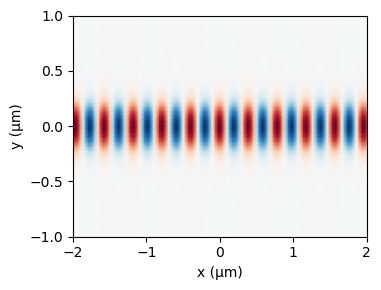

In [10]:
fig, ax = plt.subplots(figsize=(4,3))
# ax.pcolormesh(x, y, np.rot90(Eabs), cmap="inferno", shading="gouraud")
ax.pcolormesh(x, y, np.rot90(Ereal), cmap="RdBu", shading="gouraud") 
ax.axis("auto")
ax.set_xlim([-2,2])
ax.set_ylim([-1,1])
ax.set(xlabel="x (µm)", ylabel="y (µm)")
fig.tight_layout()

     prism, center = (0,4.16334e-17,5e+19)
          height 1e+20, axis (0,0,1), sidewall angle: 0 radians, 8 vertices:
          (-16,0.2,0)
          (-10,0.2,0)
          (10,6,0)
          (16,6,0)
          (16,-6,0)
          (10,-6,0)
          (-10,-0.2,0)
          (-16,-0.2,0)


          dielectric constant epsilon diagonal = (12.298,12.298,12.298)


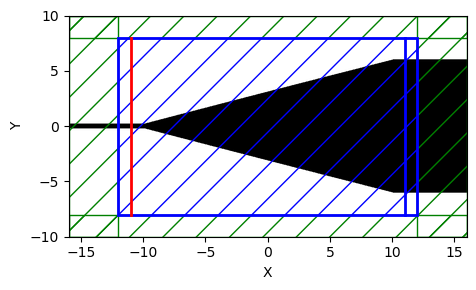

In [11]:
sim.reset_meep()

# Linear taper
vertices = [mp.Vector3(-sx/2, w1/2),
            mp.Vector3(-lx/2+L1, w1/2),
            mp.Vector3(lx/2-L2, w2/2),
            mp.Vector3(sx/2, w2/2),
            mp.Vector3(sx/2, -w2/2),
            mp.Vector3(lx/2-L2, -w2/2),
            mp.Vector3(-lx/2+L1, -w1/2),
            mp.Vector3(-sx/2, -w1/2)]

sim = mp.Simulation(resolution = resolution,
                    cell_size = cell_size,
                    boundary_layers = boundary_layers,
                    geometry = [mp.Prism(vertices, height=mp.inf, material=Si)],
                    sources = sources,
                    # symmetries = symmetries,
                    default_material = SiO2)

flux = sim.add_flux(fcen, 0, 1, 
                    mp.FluxRegion(center=mon_pt, size=mp.Vector3(0,ly)))

field = sim.add_dft_fields([mp.Ez], fcen, 0, 1,
                           center = mp.Vector3(0,0),
                           size = mp.Vector3(lx,ly))

fig, ax = plt.subplots(figsize=(5,3))
sim.plot2D(ax=ax)
ax.axis("auto")
fig.tight_layout()

In [12]:
sim.run(until_after_sources=mp.stop_when_fields_decayed(100, mp.Ez, mon_pt, 1e-9))

-----------
Initializing structure...
time for choose_chunkdivision = 0.000471115 s
Working in 2D dimensions.
Computational cell is 32 x 20 x 0 with resolution 25
     prism, center = (0,4.16334e-17,5e+19)
          height 1e+20, axis (0,0,1), sidewall angle: 0 radians, 8 vertices:
          (-16,0.2,0)
          (-10,0.2,0)
          (10,6,0)
          (16,6,0)
          (16,-6,0)
          (10,-6,0)
          (-10,-0.2,0)
          (-16,-0.2,0)
          dielectric constant epsilon diagonal = (12.298,12.298,12.298)
time for set_epsilon = 5.69466 s
-----------
MPB solved for frequency_1(2.67698,0,0) = 0.813482 after 10 iters
MPB solved for frequency_1(2.49588,0,0) = 0.763397 after 7 iters
MPB solved for frequency_1(2.49574,0,0) = 0.763359 after 3 iters
MPB solved for frequency_1(2.49574,0,0) = 0.763359 after 1 iters
on time step 3517 (time=70.34), 0.00113764 s/step
field decay(t = 100.02): 4.424501332705079e-07 / 4.424501332705079e-07 = 1.0
on time step 7074 (time=141.48), 0.00112455 

In [13]:
res = sim.get_eigenmode_coefficients(flux, [1], eig_parity = mp.ODD_Z + mp.EVEN_Y)  # Ez polarization
tran_flux = mp.get_fluxes(flux)

print("Eigenmode coefficients", res.alpha[0,0,:])
print("Transmission flux", tran_flux)
print("Forward:", abs(res.alpha[0,0,0])**2)
print("Backward:", abs(res.alpha[0,0,1])**2)

MPB solved for frequency_1(2.67698,0,0) = 0.76345 after 91 iters
MPB solved for frequency_1(2.67667,0,0) = 0.763359 after 1 iters
Dominant planewave for band 1: (2.676666,-0.000000,0.000000)
Eigenmode coefficients [ 1.0566675 -6.55099217j -0.03167262+0.19642088j]
Transmission flux [180.37657043004907]
Forward: 44.03204460082844
Backward: 0.03958431654383014


In [14]:
transmission = abs(res.alpha[0,0,0])**2 / incident_flux[0]
transmission_total = tran_flux[0] / incident_flux[0]
print(f"Transmission to fundamental mode: {transmission*100:.2f} %")
print(f"Insertion loss: {10*np.log10(transmission)} dB")
print(f"Total power transmission: {transmission_total*100:.2f} %")

Transmission to fundamental mode: 24.63 %
Insertion loss: -6.0861326011553984 dB
Total power transmission: 100.88 %


In [15]:
dft_field = sim.get_dft_array(field, mp.Ez, 0)
Eabs = np.abs(dft_field)
Ereal = np.real(dft_field)
[x, y, z, w] = sim.get_array_metadata(dft_cell=field)

print(dft_field.shape)
print(x.shape)
print(y.shape)

(602, 402)
(602,)
(402,)


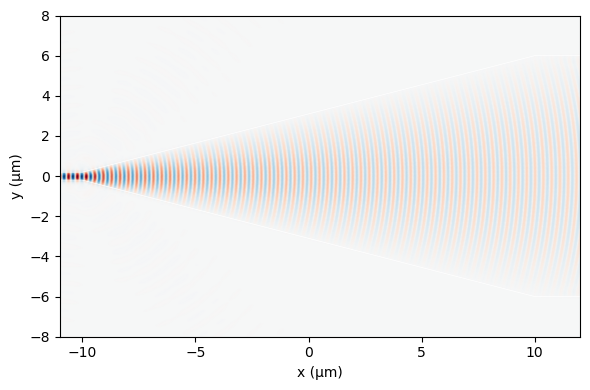

In [17]:
fig, ax = plt.subplots(figsize=(6,4))
# ax.pcolormesh(x, y, np.rot90(Eabs), cmap="inferno", shading="gouraud")
ax.pcolormesh(x, y, np.rot90(Ereal), cmap="RdBu", shading="gouraud")
ax.add_patch(Polygon([(p.x, p.y) for p in vertices], fill=False, lw=0.5, ec='w'))
ax.axis("auto")
ax.set_xlim([-lx/2+1, lx/2])
ax.set_ylim([-ly/2, ly/2])
ax.set(xlabel="x (µm)", ylabel="y (µm)")
fig.tight_layout()